## Data visualisation

In [71]:
from importlib import reload 
import datakit
import visualisationkit
reload(datakit)
reload(visualisationkit)
from datakit import *
from visualisationkit import *
import os
import warnings

pd.set_option('display.max_columns', None)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

### Load data

In [29]:
path = f'data_processed/main_new.csv'
df = pd.read_csv(path)

In [31]:
df = deduplicate_main(df)

In [32]:
df = transform_data(
    main = df,
    only_expired = True,
    duration_start = 1,
    duration_end = 28,
    utilize_morf = False
)

In [33]:
ztm_stops = pd.read_csv('geographic_data/ztm_stops/ztm_stops.csv')

In [34]:
df['distance_to_stop'] = distance_to_nearest_stop(df, ztm_stops)

In [35]:
subway_stations = ztm_stops[
    ztm_stops.stop_name.str.startswith('Metro')|
    ztm_stops.stop_name.str.contains('Wilsona')|
    ztm_stops.stop_name.str.contains('Daszyńskiego')|
    ztm_stops.stop_name.str.contains('Nowy Świat')|
    ztm_stops.stop_name.str.contains('ONZ')|
    ztm_stops.stop_name.str.contains('Wileński')|
    ztm_stops.stop_name.eq('Dw. Gdański')|
    ztm_stops.stop_name.eq('Centrum')].copy()

In [36]:
df['distance_to_subway'] = distance_to_nearest_stop(df, subway_stations)

In [37]:
legacy_data = concat_csv_files(folder_path='data_raw/otodom_scraped_data_historical')

In [38]:
legacy_data = legacy_data[~legacy_data.approximate_coordinates.eq(True)]

In [39]:
columns_to_convert = ['rent_price', 'additional_fees', 'area']
for column in columns_to_convert:
    legacy_data[column] = legacy_data[column].apply(lambda x: get_numbers(str(x)))
    
legacy_data['rent_price'] = legacy_data.apply(
    lambda row: row['rent_price'] + row['additional_fees']\
    if not pd.isna(row['additional_fees']) else row['rent_price'], 
    axis=1)

legacy_data['log_price_per_square'] = legacy_data.rent_price/legacy_data.area

In [40]:
df['avg_log_price'] = average_price_within_radius(df, legacy_data)

In [50]:
additional_columns = pd.read_csv('data_raw/other/manual_input.csv')

In [51]:
df = df.merge(additional_columns, on='link')

In [63]:
df['rent'] = df['rent'] + df['additional_fees']

### Categorical variables distributions

In [11]:
df = translate_df(df)

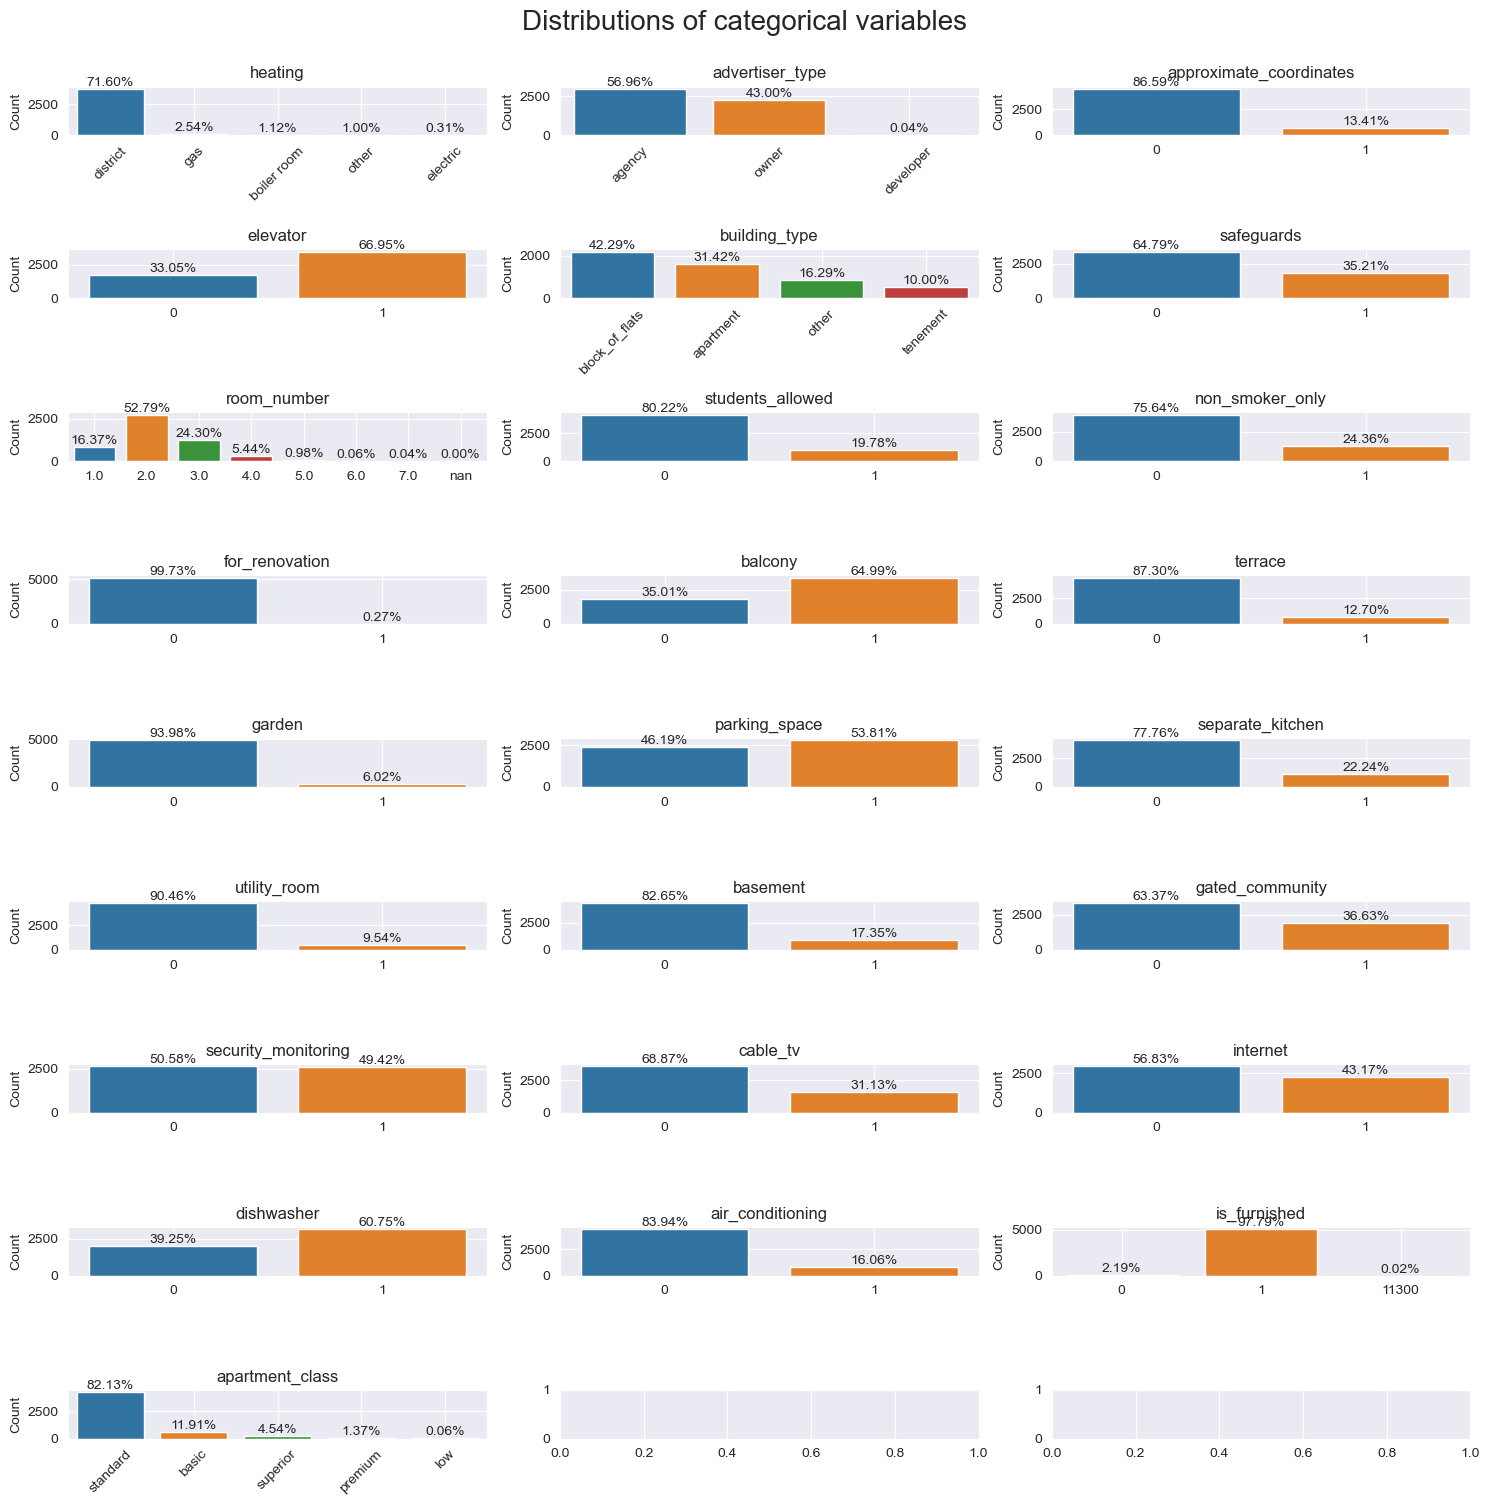

In [55]:
plot_categorical_distributions(df)

### Categorical variables distributions

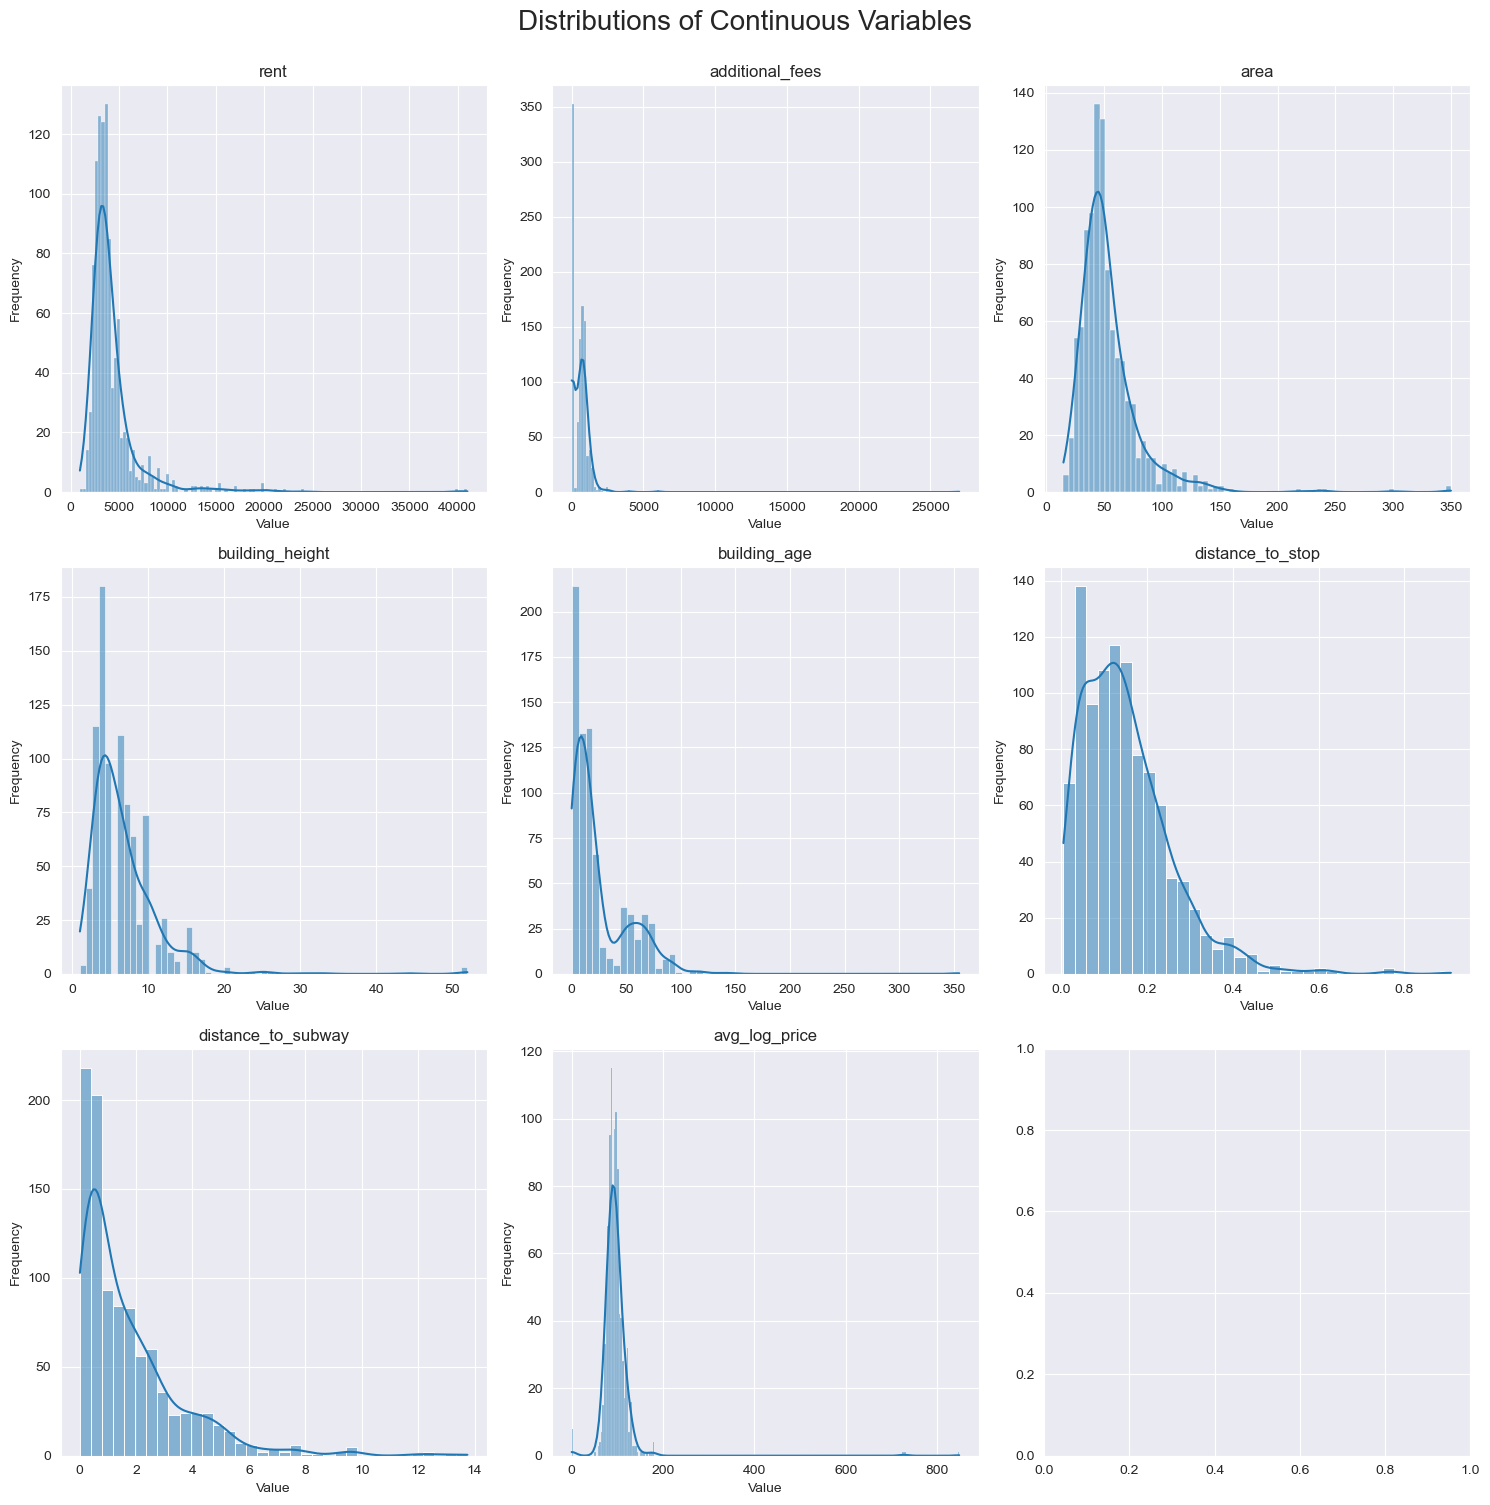

In [57]:
plot_continuous_distributions(df)

### Heat Mapsplot_heat_map_grid_cells

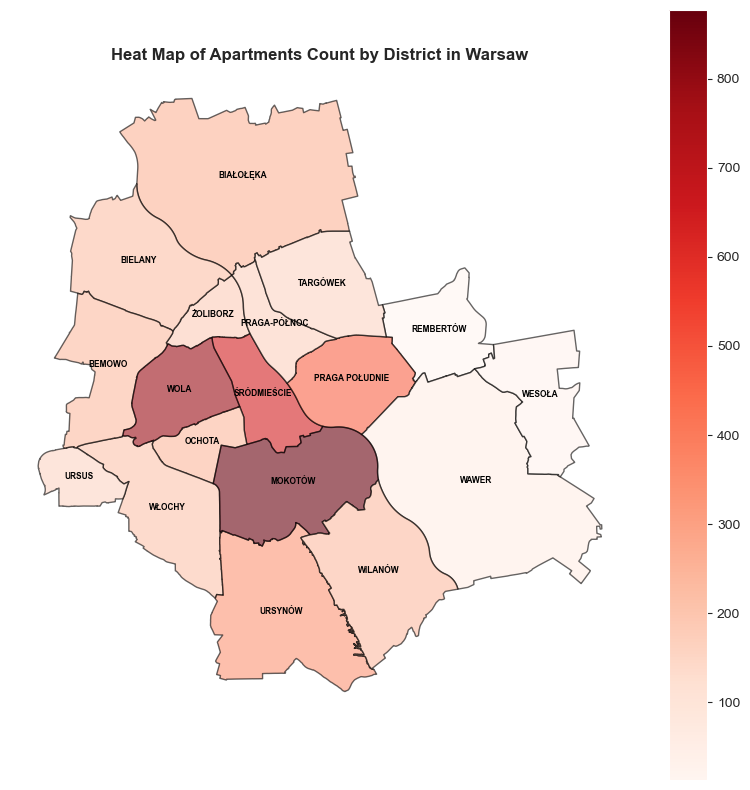

In [59]:
plot_heat_map_district(df)

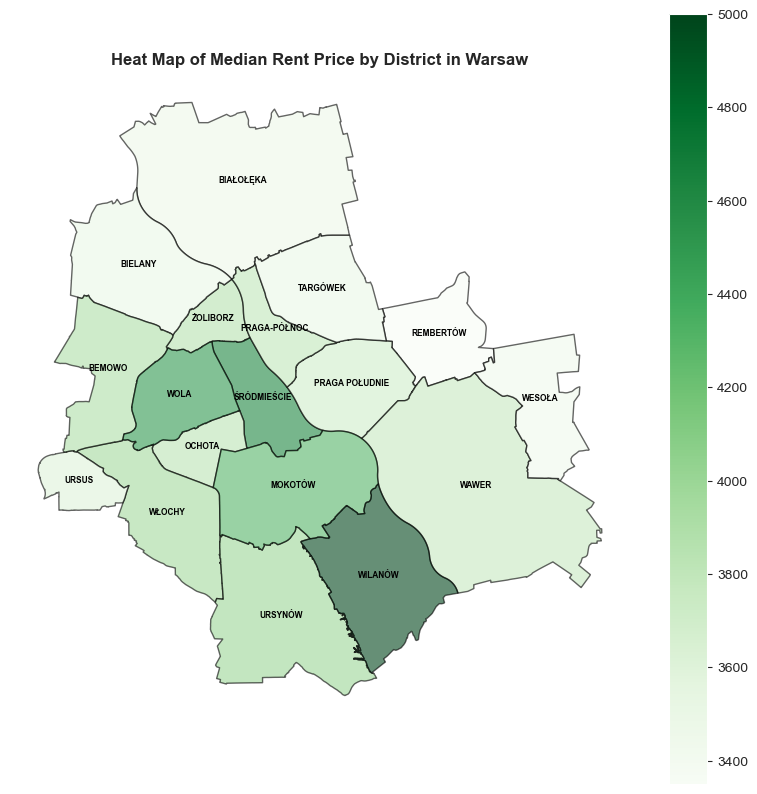

In [69]:
plot_heat_map_district(df, 'median_rent')

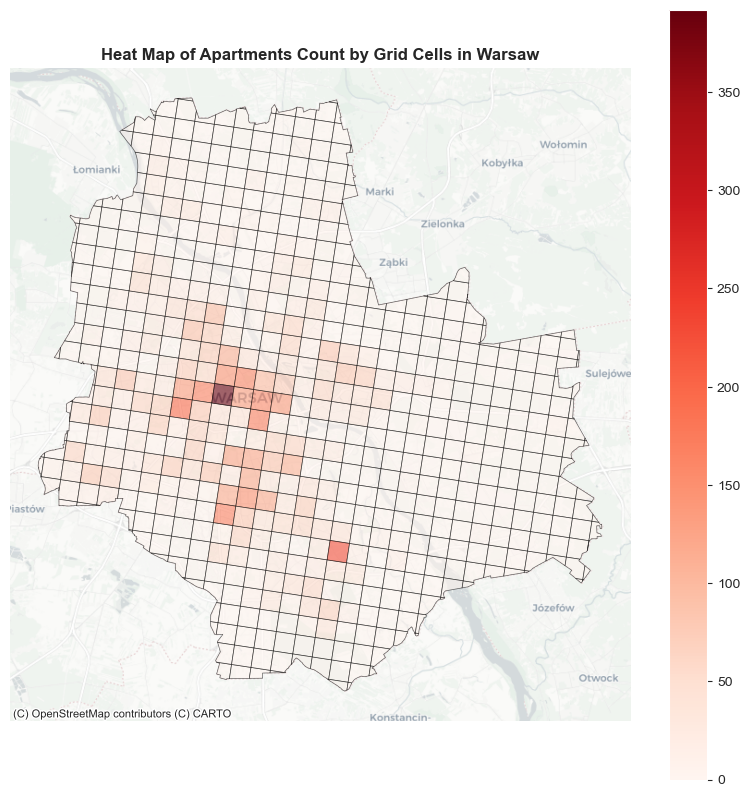

In [23]:
plot_heat_map_grid_cells(df)

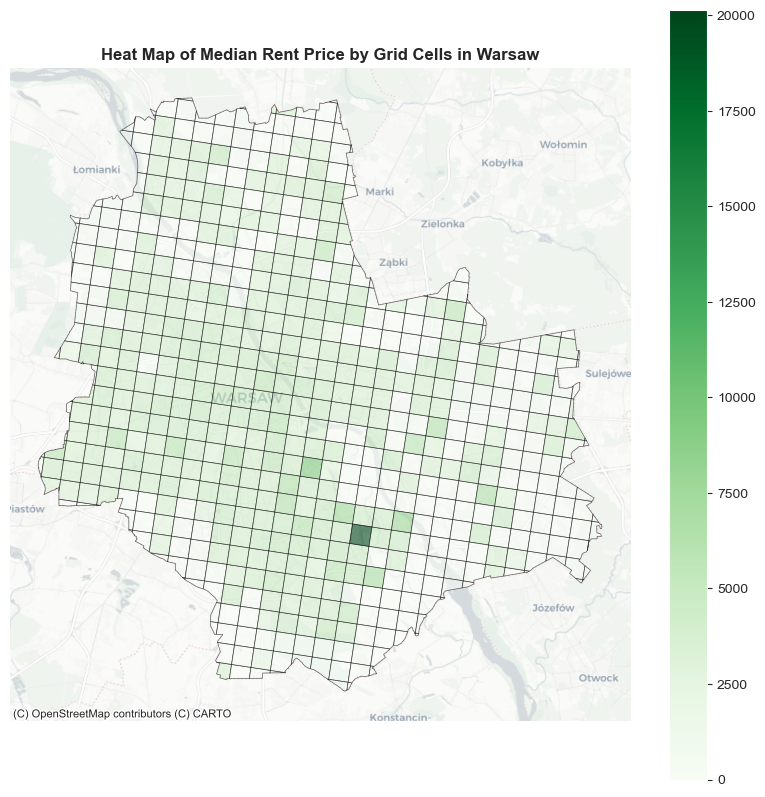

In [73]:
plot_heat_map_grid_cells(df, 'median_rent')

### Box plots

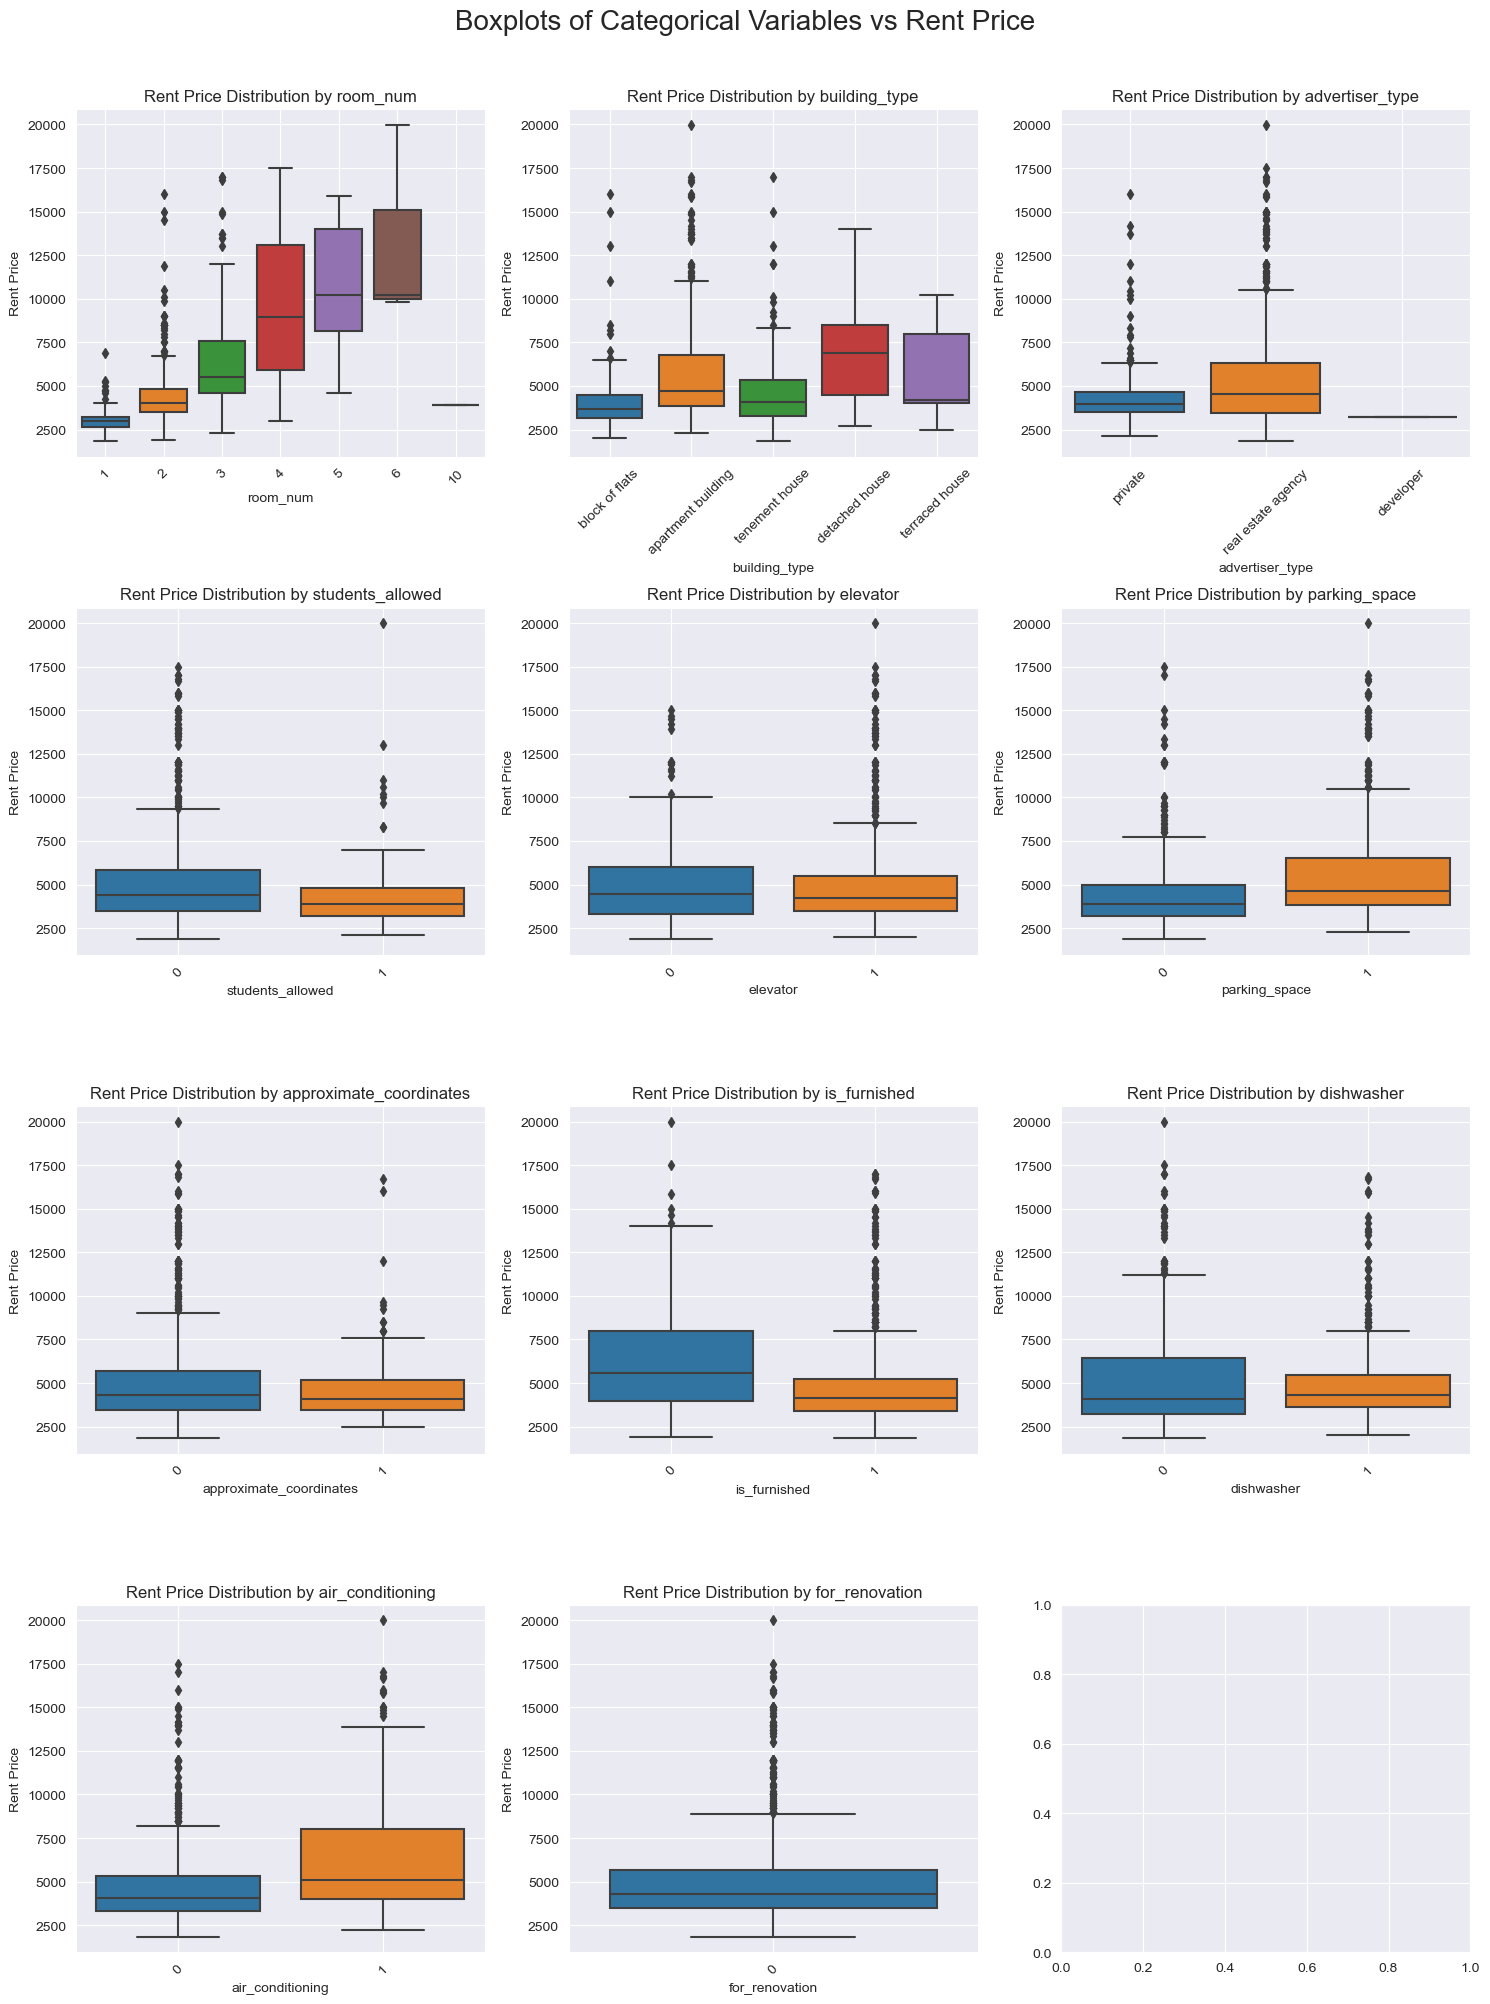

In [91]:
plot_boxplots_categorical_vs_rent(df)

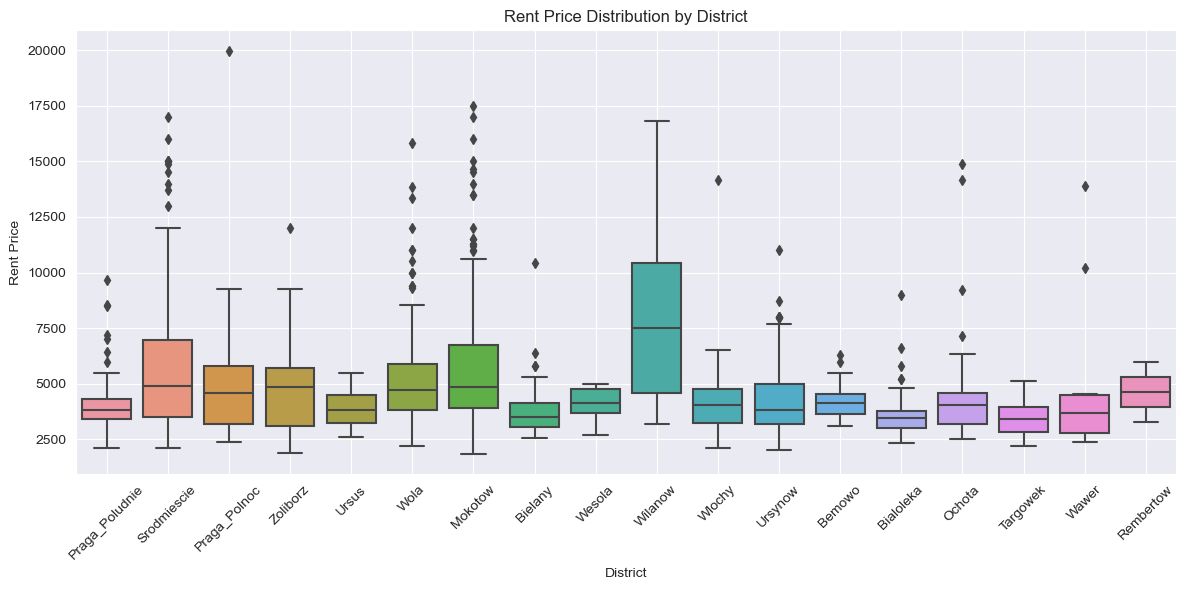

In [93]:
plot_boxplots_rent_price_by_district(df)

### Scatter plots

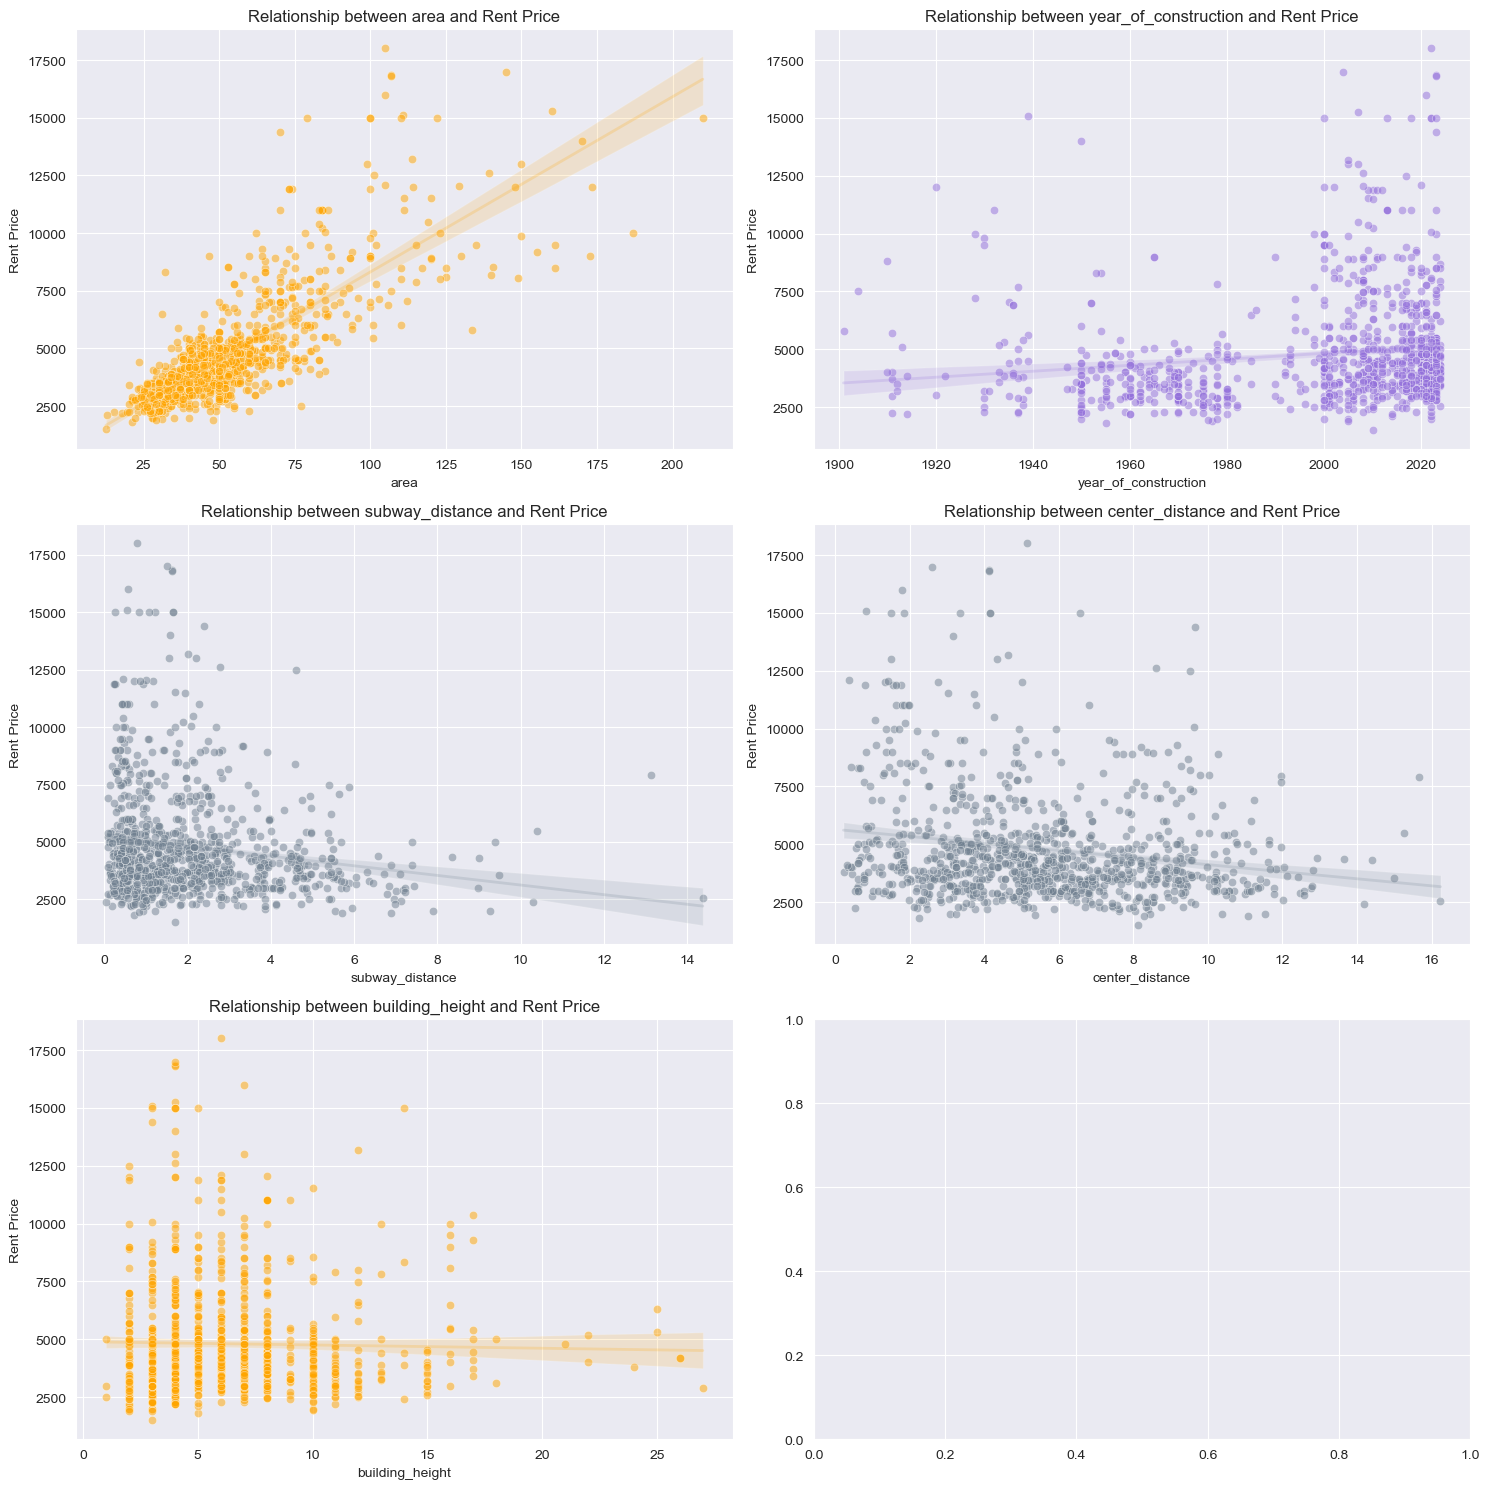

In [97]:
plot_scatter_continuous_vs_rent(df)

### =============

In [187]:
import re
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [219]:
path = f'data_processed/main.csv'
df = pd.read_csv(path)

In [220]:
df = df[~df.added_dt.isna()].copy()

In [223]:
def convert_date(date_str):
    try:
        if '.' in date_str:  # Format 1: 'DD.MM.YYYY'
            return pd.to_datetime(date_str, format='%d.%m.%Y').strftime('%Y_%m_%d')
        elif '_' in date_str:  # Format 2: 'YYYY_MM_DD'
            return pd.to_datetime(date_str, format='%Y_%m_%d').strftime('%Y_%m_%d')
    except Exception:
        return None
    
df['added_dt'] = df['added_dt'].apply(convert_date)

In [224]:
df.head(1)

,added_dt,last_update,link,expired,expired_date,title,rent_price,area_room_num,floor,ogrzewanie,flat_condition,available_from,deposit,advertiser_type,additional_information,location,latitude,longitude,approximate_coordinates,year_of_construction,elevator,building_type,security,equipment,utilities,safeguards,adv_description,district
0,2024_12_22,22.12.2024,https://www.otodom.pl/pl/oferta/piekne-mieszka...,1,2025_01_04,Piękne mieszkanie na warszawskich Skoroszach,3 000 zł\n/miesiąc\n+ Czynsz 600 zł,45m²\nWynajmę również studentom\n2 pokoje,3/6,inne,do zamieszkania,NaN,3 000 zł,prywatny,balkon\ngaraż/miejsce parkingowe,"ul. Skoroszewska, Skorosze, Ursus, Warszawa, m...",52.18975,20.899275,False,2013.0,tak,apartamentowiec,teren zamknięty\nmonitoring / ochrona,zmywarka\nlodówka\nmeble\npiekarnik\nkuchenka\...,NaN,drzwi / okna antywłamaniowe\ndomofon / wideofon,Wynajmę mieszkanie 45 metrów na warszawskim Ur...,Ursus


In [225]:
def extract_info(text):
    # Extract rent
    rent_match = re.search(r'(\d[\d\s]*)\s*([A-Za-zł]+)', text)
    rent = int(rent_match.group(1).replace(" ", "")) if rent_match else None
    rent_currency = rent_match.group(2) if rent_match else None

    # Extract additional fees
    fees_match = re.search(r'\+ Czynsz (\d[\d\s]*)\s*([A-Za-zł]+)', text)
    additional_fees = int(fees_match.group(1).replace(" ", "")) if fees_match else 0
    additional_fees_currency = fees_match.group(2) if fees_match else None

    # Extract payment frequency
    freq_match = re.search(r'/(\w+)', text)
    payment_frequency = freq_match.group(1) if freq_match else None

    return pd.Series([rent, rent_currency, additional_fees, additional_fees_currency, payment_frequency])

df[['rent', 'rent_currency', 'additional_fees', 'additional_fees_currency', 'payment_frequency']] = df['rent_price'].apply(extract_info)

In [228]:
df[['rent', 'rent_currency', 'additional_fees', 'additional_fees_currency', 'payment_frequency']]

,rent,rent_currency,additional_fees,additional_fees_currency,payment_frequency
0,3000,zł,600,zł,miesiąc
1,3950,zł,690,zł,miesiąc
2,4700,zł,750,zł,miesiąc
3,4200,zł,911,zł,miesiąc
4,7300,zł,1040,zł,miesiąc
...,...,...,...,...,...
12749,4300,zł,800,zł,miesiąc
12750,3500,zł,1000,zł,miesiąc
12751,4500,zł,1200,zł,miesiąc
12752,5480,zł,500,zł,miesiąc


In [229]:
df = df[df.rent_currency.eq('zł')&\
        (df.additional_fees_currency.eq('zł')|df.additional_fees_currency.isna())].copy()

In [230]:
df['rent_price'] = df.apply(
    lambda row: row['rent'] + row['additional_fees'] if not pd.isna(row['additional_fees']) else row['rent'], 
    axis=1)

In [234]:
df = df[df.expired.eq(1)]

In [237]:
df['added_dt'] = pd.to_datetime(df['added_dt'], format='%Y_%m_%d')
df['expired_date'] = pd.to_datetime(df['expired_date'], format='%Y_%m_%d')
df['days_difference'] = (df['expired_date'] - df['added_dt']).dt.days

In [239]:
df

,added_dt,last_update,link,expired,expired_date,title,rent_price,area_room_num,floor,ogrzewanie,flat_condition,available_from,deposit,advertiser_type,additional_information,location,latitude,longitude,approximate_coordinates,year_of_construction,elevator,building_type,security,equipment,utilities,safeguards,adv_description,district,rent,rent_currency,additional_fees,additional_fees_currency,payment_frequency,days_difference
0,2024-12-22,22.12.2024,https://www.otodom.pl/pl/oferta/piekne-mieszka...,1,2025-01-04,Piękne mieszkanie na warszawskich Skoroszach,3600,45m²\nWynajmę również studentom\n2 pokoje,3/6,inne,do zamieszkania,NaN,3 000 zł,prywatny,balkon\ngaraż/miejsce parkingowe,"ul. Skoroszewska, Skorosze, Ursus, Warszawa, m...",52.189750,20.899275,False,2013.0,tak,apartamentowiec,teren zamknięty\nmonitoring / ochrona,zmywarka\nlodówka\nmeble\npiekarnik\nkuchenka\...,NaN,drzwi / okna antywłamaniowe\ndomofon / wideofon,Wynajmę mieszkanie 45 metrów na warszawskim Ur...,Ursus,3000,zł,600,zł,miesiąc,13
1,2024-12-15,21.12.2024,https://www.otodom.pl/pl/oferta/zarezerwowane-...,1,2025-01-08,[ZAREZERWOWANE] przy Metrze Daszyńskiego,4640,42m²\n2 pokoje,2/8,miejskie,do zamieszkania,NaN,8 000 zł,prywatny,balkon\ngaraż/miejsce parkingowe,"ul. Karolkowa, Czyste, Wola, Warszawa, mazowie...",52.226621,20.978226,False,2020.0,tak,apartamentowiec,teren zamknięty\nmonitoring / ochrona,zmywarka\nlodówka\nmeble\npiekarnik\nkuchenka\...,internet,drzwi / okna antywłamaniowe\ndomofon / wideofon,English version below.\n\nMIESZKANIE\nNowoczes...,Wola,3950,zł,690,zł,miesiąc,24
2,2024-12-18,18.12.2024,https://www.otodom.pl/pl/oferta/nowe-2-pokojow...,1,2025-01-02,Nowe 2-pokojowe wysoki standard| Saska Kępa|Garaż,5450,45m²\n2 pokoje\ntylko dla niepalących,2/4,miejskie,do zamieszkania,NaN,NaN,prywatny,balkon\ngaraż/miejsce parkingowe\ntylko dla ni...,"Osiedle Lizbońska, Saska Kępa, Praga-Południe,...",52.228044,21.063960,False,2024.0,tak,apartamentowiec,monitoring / ochrona,zmywarka\nlodówka\nmeble\npiekarnik\nkuchenka\...,NaN,domofon / wideofon,Do wynajęcia NOWE 2-pokojowe mieszkanie o powi...,Praga-Południe,4700,zł,750,zł,miesiąc,15
3,2023-12-14,22.12.2024,https://www.otodom.pl/pl/oferta/3-pok-70m2-pow...,1,2025-01-09,"3 pok, 70m2, Powstańców Śl. Metro Bemowo, Garaż",5111,70m²\n3 pokoje\ntylko dla niepalących,3/7,miejskie,do zamieszkania,NaN,6 500 zł,prywatny,balkon\ntaras\ngaraż/miejsce parkingowe\npiwni...,"ul. Powstańców Śląskich 89c, Ewen Shiraz, Górc...",52.243598,20.910004,False,2008.0,tak,apartamentowiec,teren zamknięty\nmonitoring / ochrona,zmywarka\nlodówka\nmeble\npiekarnik\nkuchenka\...,NaN,domofon / wideofon,BEZPOŚREDNIO OD WŁAŚCICIELA - dostępne - Najem...,Bemowo,4200,zł,911,zł,miesiąc,392
5,2024-11-28,22.12.2024,https://www.otodom.pl/pl/oferta/2-pokojowe-mie...,1,2024-12-29,2-pokojowe mieszkanie w klimatycznej kamienicy,4200,48m²\n2 pokoje\ntylko dla niepalących,1/4,miejskie,do zamieszkania,NaN,7 000 zł,prywatny,balkon\ntaras\ntylko dla niepalących,"Nowa Praga, Praga-Północ, Warszawa, mazowieckie",52.263300,21.028320,True,2019.0,tak,kamienica,teren zamknięty,zmywarka\nlodówka\nmeble\npiekarnik\nkuchenka\...,internet,drzwi / okna antywłamaniowe\ndomofon / wideofon,Do wynajęcia 2 pokojowe mieszkanie wraz z duży...,Praga-Północ,3500,zł,700,zł,miesiąc,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12561,2025-01-30,NaN,https://www.otodom.pl/pl/oferta/kawalerka-blis...,1,2025-02-01,"Kawalerka, blisko Metro Kondratowicza",2498,34m²\nWynajmę również studentom\n1 pokój,2/2,miejskie,do zamieszkania,2025-01-30,3 000 zł,prywatny,NaN,"ul. Porannej Bryzy, Zacisze, Targówek, Warszaw...",52.290768,21.054180,False,2020.0,nie,apartamentowiec,teren zamknięty\nmonitoring / ochrona,lodówka\nmeble\npralka,NaN,drzwi / okna antywłamaniowe\ndomofon / wideofon,"Do wynajęcia niewielkie, słoneczne mieszkanie ...",Targówek,1699,zł,799,zł,miesiąc,2
12569,2025-01-30,NaN,https:

In [241]:
df[df.days_difference.eq(1)].rent_price.max()

35000

In [213]:
# df = df[df.rent_price.le(20000)]

In [245]:
df = df[df.days_difference.le(30)]

In [255]:
df[df.rent_price.ge(35000)].iloc[2,2]

'https://www.otodom.pl/pl/oferta/wyjatkowy-apartament-w-cosmopolitanie-ID4u8zi'

In [183]:
import pandas as pd
import numpy as np
import plotly.express as px
from ipywidgets import interact, IntRangeSlider
from scipy.stats import gaussian_kde

def update_histogram(days_range):
    # Filter data based on days difference range
    filtered_df = df[
        (df['days_difference'] >= days_range[0]) & 
        (df['days_difference'] <= days_range[1])
    ]
    
    # Create histogram
    fig = px.histogram(
        filtered_df, 
        x='rent_price', 
        nbins=30,
        histnorm='probability density',  # Match KDE scale
        title=f'Rent Price Distribution (Days Difference: {days_range[0]}-{days_range[1]})'
    )
    
    # Calculate kernel density estimate
    prices = filtered_df['rent_price'].dropna()
    if len(prices) > 1:  # Need at least 2 points for KDE
        kde = gaussian_kde(prices)
        x_range = np.linspace(prices.min(), prices.max(), 100)
        y_kde = kde(x_range)
        
        # Add density line
        fig.add_scatter(
            x=x_range, 
            y=y_kde, 
            mode='lines', 
            line=dict(color='red', width=2),
            name='Density Estimate'
        )
    
    fig.update_layout(showlegend=True)
    fig.show()

# Create slider
min_days = df['days_difference'].min()
max_days = df['days_difference'].max()

interact(
    update_histogram,
    days_range=IntRangeSlider(
        min=min_days,
        max=max_days,
        value=[min_days, max_days],
        step=1,
        description='Days Difference:',
        layout={'width': '500px'}
    )
)

interactive(children=(IntRangeSlider(value=(1, 30), description='Days Difference:', layout=Layout(width='500px…

<function __main__.update_histogram(days_range)>